#### This code analyzes the Sentiment of meeting minutes from Chile's Central bank
* **An overview of this code:**
* Meeting minutes can be found here:https://www.bcentral.cl/en/buscador?categoria=Prensa/Comunicados%20de%20RPM 
* The data is collected using the webscrape.ipynb notebook within the parent folder
* The minutes and dates are stored in a cleaned dataframe
* Loop over rows in the dataframe to extract the sentiment score for each row
* Each row corresponds to a month: collect FRED data for analysis of sentiment drivers
* Plot subplots of variables that relate to communication sentiment

In [67]:
import pandas as pd 
import numpy as np
import sys
from spacy_download import load_spacy
from datetime import datetime
import time
from fredapi import Fred
from datetime import datetime
import matplotlib.pyplot as plt

#Set up FRED api key
sys.path.append('../')
import config
fred = Fred(api_key=config.api_key)


In [ ]:
#Read and clean the data 
df = pd.read_csv('monpol_minutes_DB.csv')

#Fix up the dates
format_string = "%A %d de %B de %Y"
import locale
locale.setlocale(locale.LC_ALL,'es_ES.UTF-8')
df['date'] = df['date'].apply(lambda x: x.replace("\n", ""))
df['date'] = df['date'].apply(lambda x: x.strip())
df['datetime'] = df['date'].apply(lambda x: datetime.strptime(x, format_string))
df['datetime'] = df['datetime'].apply(lambda x: datetime(x.year, x.month, 1))
df = df.set_index('datetime')
#Trim unneeded columns
df = df[['headline','content']]

In [68]:
#Use the following sentiment analysis tool to process text:
#https://github.com/pysentimiento/pysentimiento

from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="es")

# Create cols to store sentiment
df['positive'] = 0
df['negative'] = 0
df['neutral'] = 0

#Loop over rows
for i in range (0,len(df)+1):
    text = df.iloc[i,1]
    #initiate textblog object
    
    # Perform sentiment analysis on the text
    sentiment = analyzer.predict(text)
    
    # Print the sentiment scores
    df.iloc[i,2] = sentiment.probas['POS']
    df.iloc[i,3] = sentiment.probas['NEG']
    df.iloc[i,4] = sentiment.probas['NEU']


loading configuration file config.json from cache at /Users/wcrossb/.cache/huggingface/hub/models--pysentimiento--robertuito-sentiment-analysis/snapshots/12e030859ce19539e24b486ac84ffebb9b68ecf1/config.json
Model config RobertaConfig {
  "_name_or_path": "pysentimiento/robertuito-sentiment-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type":

In [ ]:
#This is for demonstration purposes to check that the sentiment makes sense
#Testing on english language here, but results use the spanish text
analyzer = create_analyzer(task="sentiment", lang="en")

text_NEG = "World inflation has continued to rise and is showing signs of greater persistence. Central banks have continued to raise their reference rates. The European Central Bank began its monetary normalization process during July. The United States Federal Reserve stands out, which has taken a more contractive stance to control inflation. In this context, global growth prospects have deteriorated, amid conditions that remain unfavorable, especially for emerging economies."
text_POS = "On the external front, incoming information show that the global outlook continues on a path of recovery, consolidating prospects for this year. This is particularly noticeable in countries displaying more controlled epidemiological conditions —thanks to either effective sanitary containment measures or the progress of vaccination campaigns—, which have been able to continue with their plans to reopen their markets."

print(text_NEG)
print(f'\n The resulting sentiment: {analyzer.predict(text_NEG).probas}\n ')

print(text_POS)
print(f'\n The resulting sentiment: {analyzer.predict(text_POS).probas}')

In [69]:
#Define function for collecting data from FRED
def fredget(varlist, start_date, end_date, plots=True,freq="",name_map = dict()):
    df_collect = pd.DataFrame()

    for var in varlist:
        df_add = fred.get_series(var, observation_start = start_date, observation_end=end_date, frequency =freq).to_frame(name = var)
        info_add = fred.get_series_info(var).to_frame(name = var)
        print(var)
        #If user changes the 
        if freq != "":
            info_add.loc['cur_freq', var] = freq
            
        if var in name_map:
            info_add.loc['user_title', var] = name_map[var]
        else:
            info_add.loc['user_title', var] = info_add.loc['title', var]
                    
        if plots == True:
            df_add.plot(y=var, use_index=True, kind='line', title = info_add.loc['user_title', var], ylabel = info_add.loc['units', var] )
            
        if df_collect.empty == True:
            df_collect = df_add
            info_store = info_add
        else:
            df_collect = pd.merge(df_collect, df_add, left_index=True, right_index=True, how='outer')
            info_store = pd.merge(info_store, info_add, left_index=True, right_index=True, how='left')
            
    df_collect.sort_index()
    return df_collect, info_store


#Define FRED codes to search for 
FRED_list = ['CPALTT01CLM657N','CPGREN01CLM657N','CPGRLE01CLM657N','WPUID61','PCOPPUSDM','BAA10Y','VIXCLS','CUSR0000SAD','CCUSSP02CLM650N','IRLTLT01CLM156N','IRSTCI01CLM156N']
s_d ='2020-01-01'
e_d='2023-03-01'

#Collect variables into a monthly df
df_collect_m, dfinfo_m = fredget(FRED_list, s_d, e_d, freq = "m", plots=False)
#Convert this series to MoM % changes
df_collect_m['WPUID61'] = df_collect_m['WPUID61'].pct_change(3)*100
df_collect_m['PCOPPUSDM'] = df_collect_m['PCOPPUSDM'].pct_change(3)*100

#Rename messy names, and merge DF 
rename_cols = {"CPALTT01CLM657N":"CPI","CPGREN01CLM657N":"ENERGY","CPGRLE01CLM657N":"CORE","WPUID61":"USppi","PCOPPUSDM":"copper","CLP=X":"exrate","CL=F":"oil","CUSR0000SAD":"goods",'CCUSSP02CLM650N':'USD/CLP','IRLTLT01CLM156N':'Chile_10Y','IRSTCI01CLM156N':'Policy_Rate'}
df_collect_m = df_collect_m.rename(columns=rename_cols)
dfp = df.merge(df_collect_m, how='inner',left_index=True,right_index=True)

CPALTT01CLM657N
CPGREN01CLM657N
CPGRLE01CLM657N
WPUID61
PCOPPUSDM
BAA10Y
VIXCLS
CUSR0000SAD
CCUSSP02CLM650N
IRLTLT01CLM156N
IRSTCI01CLM156N


Text(0.5, 1.0, 'Chile: Evolution of Monetary Policy Minutes Sentiment (Late 2020 -> Present)')

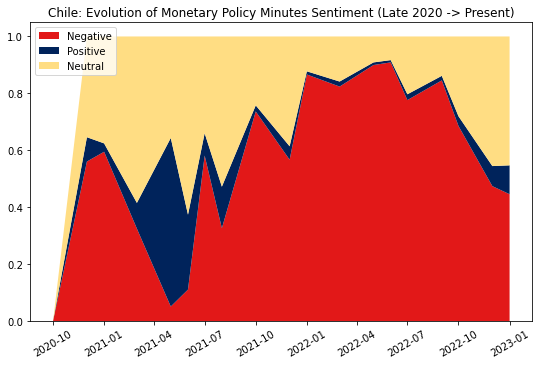

In [70]:
#Plot Stacked Area Chart of Sentiment
colpal = ['E21818', '00235B','FFDD83' ]
fig = plt.figure(figsize = (9, 5.5))
plt.xticks(rotation=30)
plt.stackplot(dfp.index,  dfp["negative"], dfp["positive"], dfp["neutral"], labels=['Negative','Positive','Neutral'],colors=colpal)
plt.legend(loc='upper left')
plt.title('Chile: Evolution of Monetary Policy Minutes Sentiment (Late 2020 -> Present)')

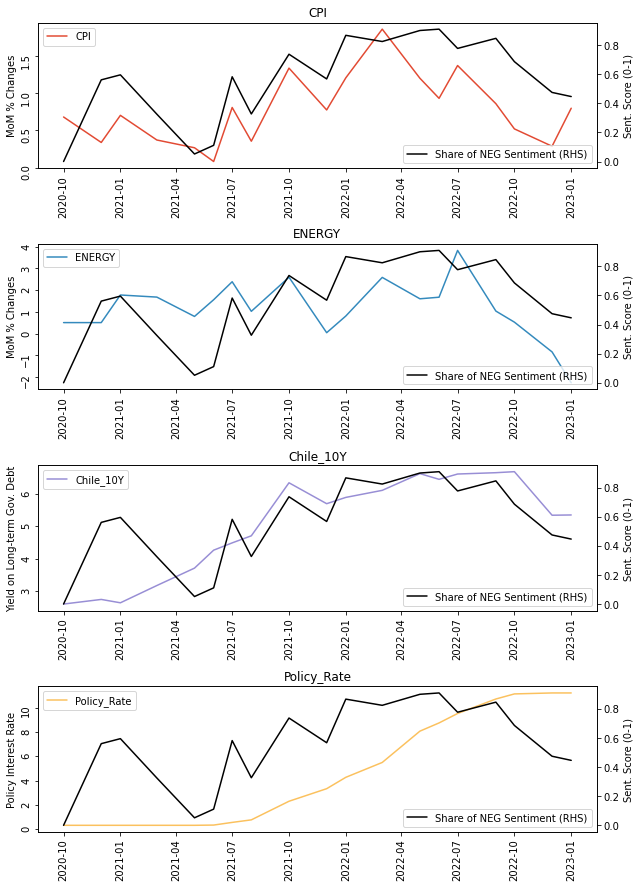

In [93]:
#Plot Negative sentiment vs. Relevant covariates
fig, axs = plt.subplots(4,1, figsize = (9, 12))

colorlist = ['#E24A33','#348ABD','#988ED5','#FBC15E','#8EBA42','#FFB5B','#777777']

cov_list = {'CPI':'MoM % Changes','ENERGY':'MoM % Changes','Chile_10Y':'Yield on Long-term Gov. Debt','Policy_Rate':'Policy Interest Rate'}
for i, var in enumerate(cov_list):
    
    fig.tight_layout()
           
    #Define plots here 
    axs[i].set_title(var)
    axs[i].tick_params(rotation=90)
    axs[i].plot(dfp[var],color = colorlist[i],label =var,solid_capstyle='round')
    axs[i].legend(loc='upper left')
    axs[i].set_ylabel(cov_list[var])
    
    ax2 = axs[i].twinx()
    ax2.plot(dfp['negative'],'k',label ='Share of NEG Sentiment (RHS)',solid_capstyle='round')
    ax2.legend(loc='lower right')
    ax2.set_ylabel('Sent. Score (0-1)')
    

**This section of code tests the frequency of words across each month**
* Remove stopwords as usual, also remove a few other common and uninformative words
* Trying to decide on the best way tro visualize this information

In [72]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import re

nltk.download('punkt')
nltk.download('stopwords')

def get_most_common_words(text, n):
    # remove non-letter characters from the text
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # tokenize the text into words
    words = word_tokenize(text.lower())

    # remove stop words
    stop_words = set(stopwords.words('spanish'))
    words = [word for word in words if word not in stop_words]
    #Also remove words like "meeting"
    secondary_list = ['reunin','ipom','plazo','septiembre']
    words = [word for word in words if word not in secondary_list]
    
    # count the frequency of each word
    word_counts = Counter(words)

    # return the n most common words
    return word_counts.most_common(n)

for i in range (0,19):
    text = df.iloc[i,1]
    #initiate textblog object
    
    # get the 5 most common words from the text
    most_common_words = get_most_common_words(text, 5)

    # print the most common words
    print(most_common_words)


[('inflacin', 8), ('respecto', 6), ('ms', 5), ('niveles', 4), ('inicios', 3)]
[('inflacin', 6), ('poltica', 5), ('monetaria', 4), ('ltima', 4), ('obstante', 3)]
[('tasas', 4), ('continan', 3), ('mercado', 3), ('ajuste', 3), ('baja', 3)]
[('inflacin', 7), ('poltica', 5), ('anual', 4), ('mundial', 3), ('mayor', 3)]
[('inflacin', 8), ('seguido', 4), ('central', 4), ('monetaria', 4), ('julio', 4)]
[('inflacin', 8), ('ms', 5), ('mercado', 5), ('precios', 4), ('escenario', 4)]
[('inflacin', 6), ('precios', 4), ('trimestre', 4), ('subiendo', 3), ('ms', 3)]
[('inflacin', 4), ('precios', 4), ('marzo', 4), ('alimentos', 3), ('global', 3)]
[('inflacin', 7), ('ms', 5), ('tasas', 4), ('aumento', 4), ('niveles', 4)]
[('torno', 6), ('inflacin', 6), ('tasas', 6), ('alza', 5), ('inters', 5)]
[('inflacin', 7), ('ms', 5), ('anual', 5), ('especialmente', 4), ('desempeo', 4)]
[('ms', 10), ('inflacin', 8), ('tasas', 5), ('aos', 5), ('anual', 5)]
[('inflacin', 6), ('mayor', 6), ('actividad', 5), ('ms', 5), (

[nltk_data] Downloading package punkt to /Users/wcrossb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wcrossb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
